# Covid X-Ray Diagnosis
## Machine Learning Final Project
### Enver Kapetanovic & Adrien Ventugol 
### Group 15

In [1]:
#import libraries 
from os import listdir
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sklearn
import imblearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as sk_mtrx

## Data Preprocessing and set up

In [2]:
#First import the paths of the pictures that we created with DataProcessor.ipynb
paths,paths_org = None,None
# Sort by covid result so we can compare the pixel distribution by test value
paths = pd.read_csv("paths.csv")

In [3]:
paths.head()

,image_path,Test
0,data_upload_v2/test/covid/9fdd3c3032296fd04d2c...,1
1,data_upload_v2/test/covid/16669_3_1.jpeg,1
2,data_upload_v2/test/covid/16663_1_1.jpg,1
3,data_upload_v2/test/covid/covid-19-pneumonia-2...,1
4,data_upload_v2/test/covid/radiol.2020201160.fi...,1


In [4]:
#initiate the list we will use to first store the pixel data, then pass into the dataframe.
pixel_data = []

In [32]:
#define a processing function to obtain transformed pixel data from the paths of the images
def to_pixel(row):
    color_img = Image.open(row["image_path"])
    resized = color_img.resize((50, 50), Image.BICUBIC) #Bicubic/Nearest resample give the best results
    sharpened = ImageEnhance.Sharpness(resized).enhance(1.5)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    pixel_data.append(np.asarray(gray_img).flatten().tolist()) #convert image to numpy array, flatten it, convert to list
    color_img.close()
    # pixel data now has the complete data of another picture at pixel_data[-1]


In [12]:
#code modified from https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
#Creates and saves Confusion Matricies as images to be used later
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0% \n0/0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="YlGnBu",annot_kws={"size": 10},
 cbar=False)
    plt.title('Confusion Matrix')
    plt.savefig(filename)

In [6]:
#apply use the functions as lambdas to apply to all the rows
paths.apply(lambda row: to_pixel(row), axis = 1)

#Separate Data into X and y
y = paths.loc[0:,'Test']
X = pd.DataFrame(data = pixel_data)

In [7]:
#check y
paths.loc[paths["Test"] == 0]

,image_path,Test
100,data_upload_v2/test/non/Lung_Lesion/patient086...,0
101,data_upload_v2/test/non/Lung_Lesion/patient069...,0
102,data_upload_v2/test/non/Lung_Lesion/patient067...,0
103,data_upload_v2/test/non/Lung_Lesion/patient061...,0
104,data_upload_v2/test/non/Lung_Lesion/patient094...,0
...,...,...
3759,data_upload_v2/train/non/Pneumonia-patient1158...,0
3760,data_upload_v2/train/non/No Finding-patient161...,0
3761,data_upload_v2/train/non/Enlarged Cardiomedias...,0
3762,data_upload_v2/train/non/Atelectasis-patient56...,0


In [8]:
#Train test split with the mean normalized X
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, train_size=.8, random_state=0)

## Logistic Regression

In [9]:
#train the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [10]:
y_score_test = lr.predict(X_test)
#metrics we are interested in
av_prec = sk_mtrx.average_precision_score(y_test, y_score_test)

#for this model we are particularly interested in maximizing recall at the detriment of precision
recall = sk_mtrx.recall_score(y_test, y_score_test, average = None)
bal_acc = sk_mtrx.balanced_accuracy_score(y_test,y_score_test)
conf = sk_mtrx.confusion_matrix(y_test, y_score_test)
f1 = sk_mtrx.f1_score(y_test, y_score_test)


print("test set:")
print(("recall score:\t\t{0}\nbalanced accuracy score: {1}\n confusion matrix:\n{2}\n"+
"f1 score: \t\t{3}").format(recall, bal_acc, conf,f1))

test set:
recall score:		[0.97910864 0.8       ]
balanced accuracy score: 0.8895543175487466
 confusion matrix:
[[703  15]
 [  7  28]]
f1 score: 		0.7179487179487181


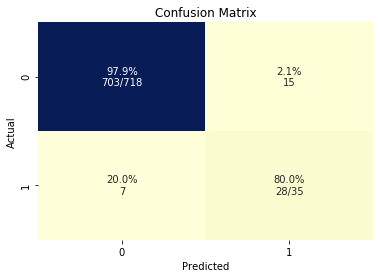

In [15]:
#generate confusion matrix
y_pred = lr.predict(X_test)
cm_analysis(y_test, y_pred, filename = 'con-matrix_LR', labels= lr.classes_, ymap=None, figsize=(6,4))

In [16]:
#Alternative metrics 
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[703  15]
 [  7  28]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       718
           1       0.65      0.80      0.72        35

    accuracy                           0.97       753
   macro avg       0.82      0.89      0.85       753
weighted avg       0.97      0.97      0.97       753



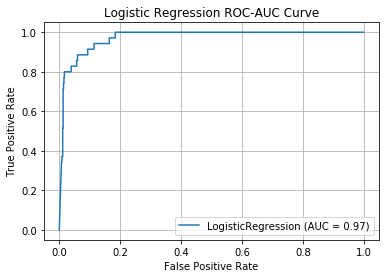

In [18]:
#Plotting ROC-AUC curve
sk_mtrx.plot_roc_curve(lr, X_test, y_test)
plt.grid()
plt.title('Logistic Regression ROC-AUC Curve')
plt.savefig('LogisticRegressionROC.jpg')

In [19]:
#Precision score using our defined metric
sk_mtrx.precision_score(y_test, y_pred, average = 'micro')

0.9707835325365206

## SVM

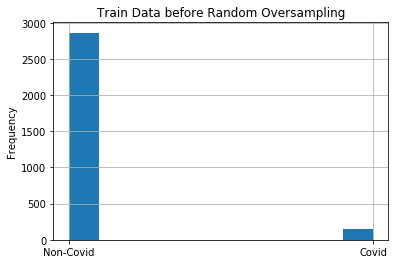

In [20]:
#SVM works best with a balanced dataset
#The graph below shows the frequency of both classes
y_train.hist()
plt.title('Train Data before Random Oversampling')
plt.ylabel('Frequency') 
positions = (0, 1)
labels = ("Non-Covid", "Covid")
plt.xticks(positions, labels)
plt.savefig('train_data_before.jpg')

In [21]:
#It is evident we have an imbalanced data-set
#Solve with Random Over Sampling Technique
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 3)
X_train,y_train = ros.fit_resample(X_train,y_train)


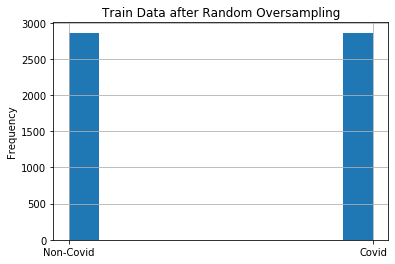

In [22]:
#Graph data frequency after random oversampling
y_train.hist()
plt.title('Train Data after Random Oversampling')
plt.ylabel('Frequency') 
positions = (0, 1)
labels = ("Non-Covid", "Covid")
plt.xticks(positions, labels)
plt.savefig('train_data_after.jpg')

In [23]:
#Training vanilla linear SVM 
from sklearn.svm import SVC
svclassifier = SVC(kernel = 'linear')
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [24]:
#Testing
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[696  22]
 [  8  27]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       718
           1       0.55      0.77      0.64        35

    accuracy                           0.96       753
   macro avg       0.77      0.87      0.81       753
weighted avg       0.97      0.96      0.96       753



Text(0.5, 1.0, 'Vanilla SVM ROC-AUC Curve')

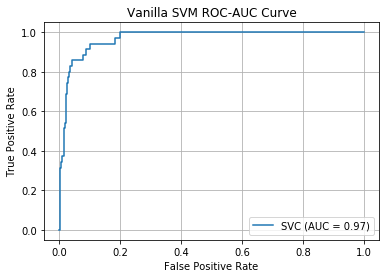

In [25]:
#Plotting ROC-AUC curve
sk_mtrx.plot_roc_curve(svclassifier, X_test, y_test)
plt.grid()
plt.title('Vanilla SVM ROC-AUC Curve')

In [27]:
#Training Poly kernel SVM 
from sklearn.svm import SVC
svclassifier2 = SVC(kernel = 'poly', degree =3)
svclassifier2.fit(X_train, y_train)

SVC(kernel='poly')

In [28]:
#Test
y_pred = svclassifier2.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[715   3]
 [  3  32]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       718
           1       0.91      0.91      0.91        35

    accuracy                           0.99       753
   macro avg       0.96      0.96      0.96       753
weighted avg       0.99      0.99      0.99       753



Text(0.5, 1.0, 'SVM with Polynomial kernel ROC-AUC Curve')

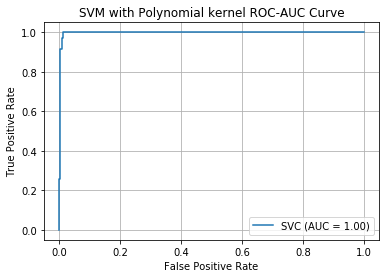

In [29]:
#Plotting AUC-ROC curve
sk_mtrx.plot_roc_curve(svclassifier2, X_test, y_test)
plt.grid()
plt.title('SVM with Polynomial kernel ROC-AUC Curve')

In [30]:
#using RBF kernel
from sklearn.svm import SVC
svclassifier3 = SVC(kernel='rbf')
svclassifier3.fit(X_train, y_train)

SVC()

In [31]:
y_pred = svclassifier3.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[718   0]
 [  2  33]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       718
           1       1.00      0.94      0.97        35

    accuracy                           1.00       753
   macro avg       1.00      0.97      0.98       753
weighted avg       1.00      1.00      1.00       753



Text(0.5, 1.0, 'SVM with RBF kernel ROC-AUC Curve')

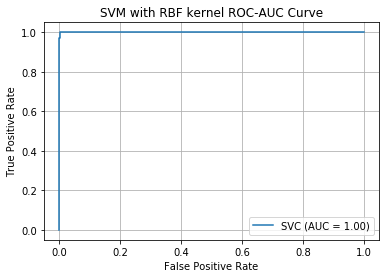

In [235]:
#Plotting
sk_mtrx.plot_roc_curve(svclassifier3, X_test, y_test)
plt.grid()
plt.title('SVM with RBF kernel ROC-AUC Curve')


In [236]:
y_score_test = svclassifier3.predict(X_test)
#metrics we are interested in
av_prec = sk_mtrx.average_precision_score(y_test, y_score_test)

#for this model we are particularly interested in maximizing recall at the detriment of precision
recall = sk_mtrx.recall_score(y_test, y_score_test, average = None)
bal_acc = sk_mtrx.balanced_accuracy_score(y_test,y_score_test)
conf = sk_mtrx.confusion_matrix(y_test, y_score_test)
f1 = sk_mtrx.f1_score(y_test, y_score_test)


print("test set:")
print(("recall score:\t\t{0}\nbalanced accuracy score: {1}\n confusion matrix:\n{2}\n"+
"f1 score: \t\t{3}").format(recall, bal_acc, conf,f1))


test set:
recall score:		[1.         0.94285714]
balanced accuracy score: 0.9714285714285714
 confusion matrix:
[[718   0]
 [  2  33]]
f1 score: 		0.9705882352941176


In [64]:
sk_mtrx.precision_score(y_test, y_pred)

1.0

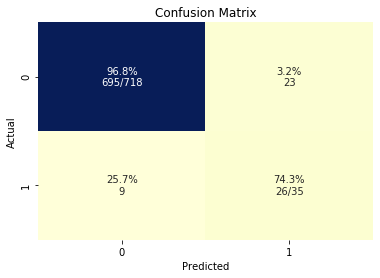

In [240]:
#Rendering Confusion Matrix image
cm_analysis(y_test, y_pred, filename = 'con-matrix', labels= svclassifier3.classes_, ymap=None, figsize=(6,4))

In [237]:
#using Sigmoid kernel
svclassifier4 = SVC(kernel='sigmoid')
svclassifier4.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [238]:
#testing
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[695  23]
 [  9  26]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       718
           1       0.53      0.74      0.62        35

    accuracy                           0.96       753
   macro avg       0.76      0.86      0.80       753
weighted avg       0.97      0.96      0.96       753



Text(0.5, 1.0, 'SVM with sigmoil kernel ROC-AUC Curve')

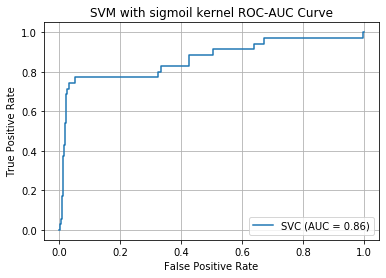

In [239]:
#plotting curve
sk_mtrx.plot_roc_curve(svclassifier4, X_test, y_test)
plt.grid()
plt.title('SVM with sigmoil kernel ROC-AUC Curve')


It is evident that the RBF kernel provides the best model, as it has the best scores all round.

## Let's try our model on pictures!
### Feel free to load your own pictures on the last line

In [242]:
cov = "Demo\\covid-demo.jpg"
non = "Demo\\normal-demo.jpg"

In [243]:
def test_model(path, model):
    pic = Image.open(path)
    pic.show()
    resized = pic.resize((50, 50), Image.BICUBIC)
    sharpened = ImageEnhance.Sharpness(resized).enhance(1.5)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    covid_pixels = np.asarray(gray_img).flatten()
    pic.close()
    covid_pixels = pd.DataFrame(data = covid_pixels).transpose()
    covid_pixels = std_scaler.transform(covid_pixels)
    if model.predict(covid_pixels)[0] == 1:
        print("The patient has covid.")
    else:
        print("The patient does not have covid.")

In [244]:
#choose model
#for logistic regression model ='lr'
#for vanilla SMV, model = 'svclassifier'
#for SVM with poly kernal, model = 'svclassifier2'
#for SVM with RBF kernal, model = 'svclassifier3'
#for SVM with sigmoid kernal, model = 'svclassifier4'
for pic in [cov,non]:
    test_model(pic, model = 'lr')

FileNotFoundError: [Errno 2] No such file or directory: 'Demo\\covid-demo.jpg'

In [ ]:
#Your turn!
#test_model(...)